In [1]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Import data
df = pd.read_csv('/Users/jimwy/OneDrive/Documents/geospatial-data-science/labs/lab5/lab5_download/seattle_house_prices.csv')
#df1 = pd.read_csv('/Users/jimwy/OneDrive/Documents/geospatial-data-science/labs/lab5/lab5_download/King_County_Demographics.csv')
# Read dataset
Wascoast = gpd.read_file('/Users/jimwy/OneDrive/Documents/geospatial-data-science/labs/lab5/lab5_download/washington_coastline.shp')
#census_tract = gpd.read_file('/Users/jimwy/OneDrive/Documents/geospatial-data-science/labs/lab5/lab5_download/census_tracts.shp')

In [3]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,lat,long
0,538000,3,2.25,2570,7242,1951,47.7210,-122.319
1,180000,2,1.00,770,10000,1933,47.7379,-122.233
2,604000,4,3.00,1960,5000,1965,47.5208,-122.393
3,510000,3,2.00,1680,8080,1987,47.6168,-122.045
4,1230000,4,4.50,5420,101930,2001,47.6561,-122.005


In [4]:
#df1.head()

In [5]:
# Check for NaN values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19451 entries, 0 to 19450
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        19451 non-null  int64  
 1   bedrooms     19451 non-null  int64  
 2   bathrooms    19451 non-null  float64
 3   sqft_living  19451 non-null  int64  
 4   sqft_lot     19451 non-null  int64  
 5   yr_built     19451 non-null  int64  
 6   lat          19451 non-null  float64
 7   long         19451 non-null  float64
dtypes: float64(3), int64(5)
memory usage: 1.2 MB


In [6]:
#df1.info()

In [7]:
#Question 1 - 19451 houses are in this dataset. There are no null values. The features I have used are ['sqft_living', 'distance_to_parks', 'distance_to_LakeWashington', 'HowMuchBedroom', 'bathrooms']

#Features best correlated with price are 'sqft_living' at 0.70226, 'bathrooms' at 0.524, and 'HowMuchBedroom' at -0.479
#Features least correlated with price are 'distance_to_Wascoast' at 0.027830, 'yr_built' at 0.052453, and 'sqft_lot' at 0.090125



In [8]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']))
gdf = gdf.set_crs(4326, allow_override=True)



# Reproject everything to UTM 10N (EPSG:32610)
gdf_utm = gdf.to_crs('EPSG:32610')
Wascoast_utm = Wascoast.to_crs('EPSG:32610')

In [9]:
#census_tract_utm = census_tract.to_crs(32610)

#census_tract.head()

In [10]:
#gdf_utm_tract = gdf_utm.sjoin(census_tract_utm)


In [11]:
#gdf_utm_tract.head()

In [30]:
#Compute distance to UW Arboretum
#47.63982848173617, -122.29614021004966
from shapely.geometry import Point
geom = Point( -122.28120001226782, 47.6167207495107)
geom_gdf = gpd.GeoDataFrame(geometry = [geom], crs = 4326)
geom_gdf = geom_gdf.to_crs("EPSG:32610")

distance_to_Arboretum = []
for i in range(gdf_utm.shape[0]):
    distance_to_Arboretum.append(geom_gdf.distance(gdf_utm['geometry'].iloc[i]).min())
    
# Add to DataFrame
gdf_utm['distance_to_Arboretum'] = distance_to_Arboretum

#Compute Distance to Bill Gates street
BillHouse =  Point( -122.23906489686838, 47.61585908737864)
#ParkPoints_gdf = gpd.GeoDataFrame(geometry = [geom], crs = 4326)
BillHouse_gdf = gpd.GeoDataFrame(geometry = [BillHouse], crs = 4326)
BillHouse_gdf = BillHouse_gdf.to_crs("EPSG:32610")

distance_to_Bill = []
for i in range(gdf_utm.shape[0]):
    distance_to_Bill.append(BillHouse_gdf.distance(gdf_utm['geometry'].iloc[i]).min())
    
gdf_utm['distance_to_Bill'] = distance_to_Bill

#Compute Distance to Park points
#47.65505093674864, -122.30285131857873
ParkPoints =  [Point(-122.18125695820727, 47.65622068164255),Point( -122.19429496153904,47.61386529504444,)]
#ParkPoints_gdf = gpd.GeoDataFrame(geometry = [geom], crs = 4326)
ParkPoints_gdf = gpd.GeoDataFrame(geometry = ParkPoints, crs = 4326)
ParkPoints_gdf = ParkPoints_gdf.to_crs("EPSG:32610")

distance_to_parks = []
for i in range(gdf_utm.shape[0]):
    distance_to_parks.append(ParkPoints_gdf.distance(gdf_utm['geometry'].iloc[i]).min())
    
gdf_utm['distance_to_parks'] = distance_to_parks

# Compute distance to coast
distance_to_Wascoast = []
for i in range(gdf_utm.shape[0]):
    distance_to_Wascoast.append(Wascoast_utm.distance(gdf_utm['geometry'].iloc[i]).min())
    
# Add to DataFrame
gdf_utm['distance_to_Wascoast'] = distance_to_Wascoast


#Compute Distance to Maydenbauer Bay park
maypark =  Point (-122.21127591938422, 47.6127248097697 )
maypark_gdf = gpd.GeoDataFrame(geometry = [maypark], crs = 4326)
maypark_gdf = maypark_gdf.to_crs("EPSG:32610")

distance_to_Maydenbauer = []
for i in range(gdf_utm.shape[0]):
    distance_to_Maydenbauer.append(maypark_gdf.distance(gdf_utm['geometry'].iloc[i]).min())
    
gdf_utm['distance_to_Maydenbauer'] = distance_to_Maydenbauer


In [43]:
#Compute Distance to BMW dealership of Bellevue
BellevueBMW =  Point( -122.18243944100615, 47.63083407952265 )
BellevueBMW_gdf = gpd.GeoDataFrame(geometry = [BellevueBMW], crs = 4326)
BellevueBMW_gdf = LakeWas_gdf.to_crs("EPSG:32610")

distance_to_BellevueBMW = []
for i in range(gdf_utm.shape[0]):
    distance_to_BellevueBMW.append(BellevueBMW_gdf.distance(gdf_utm['geometry'].iloc[i]).min())
    
gdf_utm['distance_to_BellevueBMW'] = distance_to_BellevueBMW


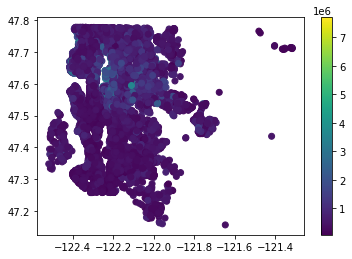

In [13]:
# Quickly check that it worked!
plt.scatter(gdf_utm['long'], gdf_utm['lat'], c=gdf_utm['price'])
plt.colorbar()

In [45]:
gdf_utm.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built',
       'lat', 'long', 'geometry', 'distance_to_Arboretum', 'distance_to_Bill',
       'distance_to_parks', 'distance_to_Wascoast',
       'distance_to_LakeWashington', 'bedandbath', 'HowMuchBedroom',
       'distance_to_Maydenbauer', 'distance_to_BellevueBMW'],
      dtype='object')

In [46]:
gdf_utm.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,yr_built,lat,long,distance_to_Arboretum,distance_to_Bill,distance_to_parks,distance_to_Wascoast,distance_to_LakeWashington,bedandbath,HowMuchBedroom,distance_to_Maydenbauer,distance_to_BellevueBMW
count,1.945100e+04,19451.000000,19451.000000,19451.000000,1.945100e+04,19451.000000,19451.000000,19451.000000,19451.000000,19451.000000,19451.000000,19451.000000,19451.000000,19451.000000,19451.000000,19451.000000,19451.000000
mean,5.404634e+05,3.369955,2.114943,2081.149967,1.508406e+04,1971.021438,47.559780,-122.213896,17577.839631,17282.067809,16526.494005,11361.467248,17972.068029,5.484898,0.001793,17278.414525,17972.068029
std,3.685123e+05,0.906639,0.769818,918.160494,4.160157e+04,29.363143,0.138783,0.140694,10322.279251,9675.053748,9616.226472,9540.501421,9733.762622,1.466980,0.000569,9271.470590,9733.762622
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1900.000000,47.155900,-122.519000,67.656932,89.427491,318.429640,1.284621,529.112054,0.000000,0.000000,109.473974,529.112054
25%,3.210000e+05,3.000000,1.750000,1420.000000,5.042500e+03,1952.000000,47.469500,-122.328000,10076.414958,10631.544801,9789.212895,3286.564007,11239.306911,4.500000,0.001384,11173.257924,11239.306911
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.620000e+03,1975.000000,47.571700,-122.231000,14706.949034,14349.435795,14332.407508,9544.295888,15764.231807,5.500000,0.001734,14943.523831,15764.231807
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.066550e+04,1997.000000,47.677900,-122.125000,23032.664736,21725.538117,20420.365621,16855.592243,22050.805908,6.500000,0.002128,21446.278373,22050.805908
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,2015.000000,47.777600,-121.315000,73331.928027,70219.092203,65602.342220,74308.874771,66523.888605,16.500000,0.006122,68216.315255,66523.888605


In [16]:
# Bedroom + bathroom
gdf_utm['bedandbath'] = gdf_utm['bedrooms'] + gdf_utm['bathrooms']

# HowMuchBedroom
gdf_utm['HowMuchBedroom'] = gdf_utm['bedrooms'] / gdf_utm['sqft_living']


#gdf_utm['HowMuchBath'] = gdf_utm['bathrooms'] / gdf_utm['sqft_living']

In [49]:
gdf_utm = gdf_utm.loc[:, gdf_utm.columns != "HowMuchBath"]
gdf_utm = gdf_utm.loc[:, gdf_utm.columns != ""]
gdf_utm = gdf_utm.loc[:, gdf_utm.columns != "housingSpace"]
gdf_utm = gdf_utm.loc[:, gdf_utm.columns != "distance_to_LakeWashington"]

In [50]:
gdf_utm.columns


Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built',
       'lat', 'long', 'geometry', 'distance_to_Arboretum', 'distance_to_Bill',
       'distance_to_parks', 'distance_to_Wascoast', 'bedandbath',
       'HowMuchBedroom', 'distance_to_Maydenbauer', 'distance_to_BellevueBMW'],
      dtype='object')

In [51]:
# Compute correlation matrix
corr_matrix = gdf_utm.corr()

# Display just house value correlations
corr_matrix["price"].sort_values(ascending= False)

price                      1.000000
sqft_living                0.702296
bathrooms                  0.524395
bedandbath                 0.470360
bedrooms                   0.315804
lat                        0.308082
sqft_lot                   0.090125
yr_built                   0.052453
distance_to_Wascoast       0.027830
long                       0.020092
distance_to_Arboretum     -0.352885
distance_to_Bill          -0.392472
distance_to_parks         -0.403275
distance_to_Maydenbauer   -0.408390
distance_to_BellevueBMW   -0.420832
HowMuchBedroom            -0.479228
Name: price, dtype: float64

In [52]:
# Define feature list
feature_list =  ['sqft_living', 'distance_to_Maydenbauer', 'distance_to_BellevueBMW', 'HowMuchBedroom', 'bathrooms', 'bedandbath', 'distance_to_Bill', 'distance_to_parks']

# Define features and labels 
X = gdf_utm[feature_list]
y = gdf_utm['price']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [57]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [60]:
# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

In [61]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

174415.32348571054

(0.0, 500000.0)

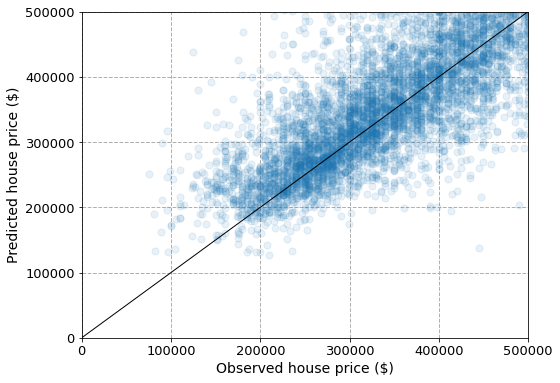

In [62]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,500000], [0, 500000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted house price ($)', fontsize=14)
ax.set_xlabel('Observed house price ($)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,500000)
ax.set_xlim(0,500000)